In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import geemap
import geemap.colormaps as cm
import ee

import seaborn

import datetime
from pathlib import Path

import importlib
import ee_downloader 
importlib.reload(ee_downloader)
from ee_downloader import EEDownloader

In [2]:
ee.Authenticate()
ee.Initialize(project='sentinel-treeclassification')

In [10]:
figure_dir = Path('report', 'figures_labels')

Data source: https://figshare.com/collections/A_high-resolution_pan-European_tree_occurrence_dataset/3288407

In [4]:
df = pd.read_csv(Path('labels').joinpath('EUForestspecies.csv'))
df.shape, df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588983 entries, 0 to 588982
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   X             588983 non-null  int64 
 1   Y             588983 non-null  int64 
 2   COUNTRY       588983 non-null  object
 3   SPECIES NAME  588983 non-null  object
 4   DBH-1         588983 non-null  int64 
 5   DBH-2         588983 non-null  int64 
 6   NFI           588983 non-null  int64 
 7   FF            588983 non-null  int64 
 8   BS            588983 non-null  int64 
 9   EEO           588983 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 44.9+ MB


((588983, 10),
          X        Y  COUNTRY SPECIES NAME  DBH-1  DBH-2   NFI    FF    BS  EEO
 0  4305500  2674500  Austria   Abies alba  -9999  -9999 -9999     1 -9999    1
 1  4576500  2705500  Austria   Abies alba      1      1     1 -9999 -9999    1
 2  4570500  2721500  Austria   Abies alba      1      1     1 -9999 -9999    1
 3  4300500  2663500  Austria   Abies alba  -9999      1     1 -9999 -9999    1
 4  4610500  2811500  Austria   Abies alba  -9999      1     1 -9999 -9999    1,
 None)

In [5]:
df[['X', 'Y']].value_counts()

X        Y      
4638500  2148500    24
4669000  2525000    24
4697000  2591000    22
3960500  2820000    22
4701000  2527500    20
                    ..
1562500  1027500     1
5813500  2634500     1
5816500  2632500     1
5818500  2633500     1
5821500  2631500     1
Name: count, Length: 250569, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

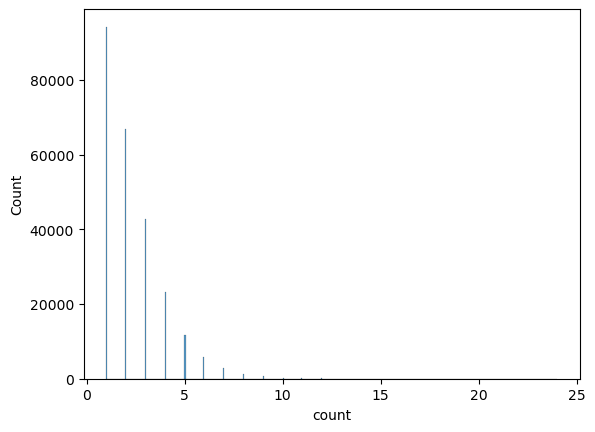

In [8]:
df[['X', 'Y']].value_counts()

In [7]:
df[['X', 'Y']].value_counts().shape, df['SPECIES NAME'].unique().shape, df['SPECIES NAME'].value_counts()

((250569,),
 (242,),
 SPECIES NAME
 Pinus sylvestris          75720
 Picea abies               70310
 Fagus sylvatica           35862
 Quercus robur             31079
 Betula pubescens          26676
                           ...  
 Salix daphnoides              1
 Populus balsamifera           1
 Frangula rupestris            1
 Sorbus graeca                 1
 Tetraclinis articulata        1
 Name: count, Length: 242, dtype: int64)

<Axes: >

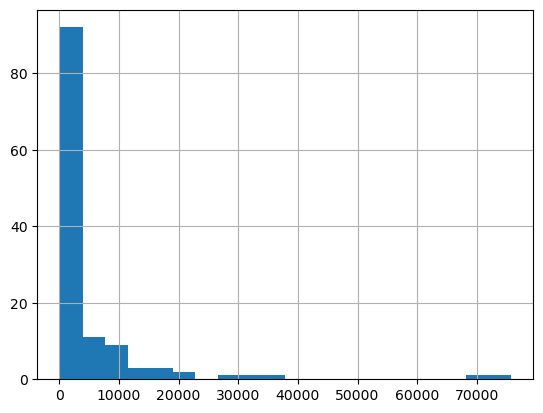

In [7]:
df['SPECIES NAME'].value_counts()[df['SPECIES NAME'].value_counts()>=100].hist(bins=20)

<Axes: >

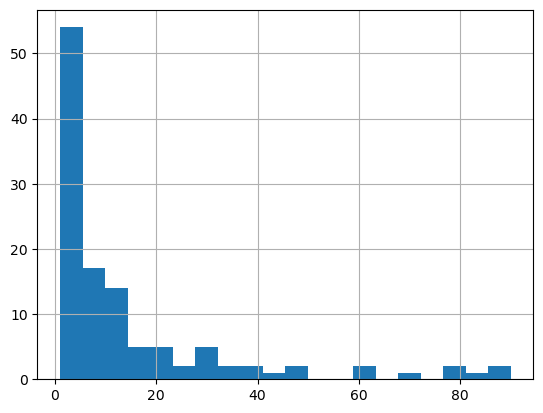

In [8]:
df['SPECIES NAME'].value_counts()[df['SPECIES NAME'].value_counts()<100].hist(bins=20)

In [9]:
grouped = df[['X', 'Y', 'SPECIES NAME']].groupby(['X', 'Y'], as_index=False).agg({'SPECIES NAME': ', '.join})
# grouped.to_csv('plots.csv', index=False)
grouped.shape, grouped.head()

((250569, 3),
          X        Y       SPECIES NAME
 0  1551500  1033500      Pinus radiata
 1  1552500  1032500  Pinus canariensis
 2  1553500  1031500  Pinus canariensis
 3  1553500  1032500  Pinus canariensis
 4  1554500  1031500  Pinus canariensis)

In [10]:
gdf = gpd.GeoDataFrame(
    grouped.drop(labels=['X', 'Y'], axis=1), 
    geometry=gpd.points_from_xy(x=grouped.X, y=grouped.Y, crs='EPSG:3035')
)
gdf.geometry = gdf.buffer(500, cap_style=3).to_crs(epsg=4326)
gdf.head()

,SPECIES NAME,geometry
0,Pinus radiata,"POLYGON ((-18.11660 27.73646, -18.11376 27.727..."
1,Pinus canariensis,"POLYGON ((-18.10417 27.73111, -18.10133 27.722..."
2,Pinus canariensis,"POLYGON ((-18.09174 27.72575, -18.08891 27.717..."
3,Pinus canariensis,"POLYGON ((-18.09458 27.73434, -18.09174 27.725..."
4,Pinus canariensis,"POLYGON ((-18.08215 27.72898, -18.07932 27.720..."


In [11]:
# Add some padding to avoid border polygons being cut off.
bbox = ee.Geometry.BBox(*(gdf.geometry.total_bounds + 0.01))

In [12]:
def visualise(gdf, bbox):
    rgb_bands = ['B4', 'B3', 'B2']
    visualization = {
        'min': 1,
        'max': 3000,
        'bands': rgb_bands
    }
    
    start_date = datetime.datetime(2017, 3, 1)
    end_date = datetime.datetime(2020, 3, 1)
    
    image = EEDownloader().get_sentinel_image(start_date, end_date).clip(bbox)
    
    m = geemap.geemap.Map()
    
    center = (np.array(bbox.getInfo()['coordinates'][0][2]) + np.array(bbox.getInfo()['coordinates'][0][0]))/2
    
    m.set_center(*center, 7)
    
    style = {"stroke": True, "color": "green",
             "weight": 2, "opacity": 1, "fillOpacity": 0.1
    }
    
    m.add_gdf(gdf, layer_name='euforest', style=style)
    
    m.addLayer(image, visualization, 'RGB')

    gdf_points = gdf
    gdf_points.geometry = gdf_points.geometry.centroid
    m.addLayer(
        geemap.geopandas_to_ee(gdf_points),
        {}, 'points'
    )
    
    earth_url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
    m.add_tile_layer(earth_url, name='Google Earth', attribution='Google')
    
    m.addLayerControl(position='topright')
    return m
visualise(gdf.head(1000), bbox)

Map(center=[49.0960166662788, 7.636469936494468], controls=(WidgetControl(options=['position', 'transparent_bg…

Although it wouldn't matter for training purposes, the centering of each cell matters for comparisons with, e.g TreeSatAI. I expected all EU Forest data to be centered at midway points of 1 km cells, so all coordinates would end with 500 instead of 000. As shown below, that's not the case entirely.

In [13]:
uncentered_mask = (grouped['X'] % 1000 != 500) | (grouped['Y'] % 1000 != 500)
uncentered_mask.sum()

7666

In [14]:
# visualise(gdf[uncentered_mask], bbox)

In [15]:
dummy_labels = gdf['SPECIES NAME'].str.get_dummies(sep=', ').astype(float)
dummy_gdf = gpd.GeoDataFrame(dummy_labels.join(gdf['geometry']), geometry='geometry')

In [16]:
dummies_file = Path('data').joinpath('full_dummies.csv')
if not dummies_file.is_file():
    dummy_gdf.drop('geometry', axis=1).to_csv(dummies_file, index=False)

geometries_file = Path('data').joinpath('full_geometries.json')
if not geometries_file.is_file():
    print(type(dummy_gdf))
    dummy_gdf[['geometry']].to_file(geometries_file, driver='GeoJSON')